In [1]:
from __future__ import print_function, division
import copy
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
import torchvision
print(torch.__version__)
print(torchvision.__version__)

%matplotlib inline

0.4.1
0.2.1


In [2]:
class DeepLesionDataset(Dataset):
    """DeepLesion dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_table(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):


        img_name = os.path.join(self.root_dir,
                                os.path.join(
                                    *self.data_frame.iloc[idx, 0].rsplit('_', 1)
                                ))

        image = io.imread(img_name).astype(np.int32)
#         image = np.expand_dims(image, axis=2)
        image = image - 32768
        image = image.astype(np.int32)
        

        
        img_min = image.min()
        img_max = image.max()
        
        low_bound = -500
        high_bound = 500
        
        
        channel_1 = (((image-img_min)/(low_bound-img_min))*255).clip(0, 255)
        channel_2 = (((image-low_bound)/(high_bound-low_bound))*255).clip(0, 255)
        channel_3 = (((image-high_bound)/(img_max-high_bound))*255).clip(0, 255)

        image = np.zeros((3, image.shape[0], image.shape[1]))
        image[0] = channel_1
        image[1] = channel_2
        image[2] = channel_3
        image = image.astype(np.uint8).transpose(1,2,0)

        bounding_box = np.array(self.data_frame.iloc[idx].Bounding_boxes.split(','))
        bounding_box = bounding_box.astype('float').reshape(-1, 2)
        label = self.data_frame.iloc[idx].Coarse_lesion_type.astype(int) - 1


#         bounding_box = [c_x1, c_y1, c_x2, c_y2]

        
        # TODO: Needs to be relative to the cell
        c_x =  ((bounding_box[1][0] + bounding_box[0][0])/2) / image.shape[0]
        c_y =  ((bounding_box[1][1] + bounding_box[0][1])/2) / image.shape[1]
        c_hw = (bounding_box[1][0] - bounding_box[0][0]) / image.shape[0]
        c_hh = (bounding_box[1][1] - bounding_box[0][1]) / image.shape[1]
#         c_x1 = bounding_box[0][0] / image.shape[0]
#         c_y1 = bounding_box[0][1] / image.shape[1]
#         c_x2 = bounding_box[1][0] / image.shape[0]
#         c_y2 = bounding_box[1][1] / image.shape[1]

       
        grid_dim = 7
        target = torch.zeros((grid_dim,grid_dim,11))
        
        cell_dim = 1 / grid_dim
        target[int(c_y // cell_dim), int(c_x // cell_dim),0] = c_x - (int(c_x // cell_dim))/7 - 1/14
        target[int(c_y // cell_dim), int(c_x // cell_dim),1] = c_y - (int(c_y // cell_dim))/7 - 1/14
        target[int(c_y // cell_dim), int(c_x // cell_dim),2] = c_hw
        target[int(c_y // cell_dim), int(c_x // cell_dim),3] = c_hh
        target[int(c_y // cell_dim), int(c_x // cell_dim),4] = 1 # b1_c
        
        target[int(c_y // cell_dim), int(c_x // cell_dim),5] = c_x - int(c_x // cell_dim)/7 - 1/14
        target[int(c_y // cell_dim), int(c_x // cell_dim),6] = c_y - int(c_y // cell_dim)/7 - 1/14
        target[int(c_y // cell_dim), int(c_x // cell_dim),7] = c_hw
        target[int(c_y // cell_dim), int(c_x // cell_dim),8] = c_hh
        target[int(c_y // cell_dim), int(c_x // cell_dim),9] = 1 # b2_c
        
        target[int(c_y // cell_dim), int(c_x // cell_dim),10] = 1 # c_c
                
        if self.transform:
            image = self.transform(image)
    
    
        return image, target

d = DeepLesionDataset('../sets/train_set_small.tsv', '/media/mark/Data/deeplesion/Images_png',
                     transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                     ])
                     )

# p_bb = []#
# t_bb = conf_bboxes(d[0][1])
# imshow(inputs[0].cpu(), t_bb, p_bb)
# for i in d:
#     pass
# print(d[0][0].numpy().transpose(1, 2, 0).shape)
# for row in d[0][0].squeeze().numpy():
#     print(row)
# plt.close('all')
# fig,ax = plt.subplots(1, figsize=(5,5))
# fig = plt.figure(figsize=(5, 5))
# _ = plt.imshow(d[0][0].squeeze().numpy())
# plt.show()
# bb_x = d['bounding_box'][0,0]
# bb_y = d['bounding_box'][0,1]
# bb_w = d['bounding_box'][1,0] - d['bounding_box'][0,0] 
# bb_h = d['bounding_box'][0,1] - d['bounding_box'][1,1]
# rect1 = patches.Rectangle((bb_x,bb_y),bb_w,bb_h,linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect1)

In [16]:
# source: https://github.com/kevin970401/pytorch-YOLO-v1/blob/master/utils/utils.py

def conf_bboxes(pred, conf=0.2):
    S = pred.shape[0]
    dims = pred[:,:,:10]
    classes = pred[:,:,10:]
    bboxes = []
    for j in range(S):
        for i in range(S):
            for b in range(2):
                c = dims[j,i][4 + b*5].item()
                if c > conf:
                    x_c = dims[j,i][0 + b*5].item()
                    y_c = dims[j,i][1 + b*5].item()
                    x_c += i/7 + 1/14
                    y_c += j/7 + 1/14
                    w = dims[j,i][2 + b*5].item()
                    h = dims[j,i][3 + b*5].item()
                    x0 = x_c - w/2
                    y0 = y_c - h/2
                    l = classes[j,i].item()
                    bboxes.append((x0, y0, w, h, c, l))
    return bboxes
                

t_bb = conf_bboxes(d[0][1])   
print(t_bb)

[(0.5073769520968199, 0.653033203578421, 0.026501953601837158, 0.029289063066244125, 1.0, 1.0), (0.5073769520968199, 0.653033203578421, 0.026501953601837158, 0.029289063066244125, 1.0, 1.0)]


In [4]:
def imshow(inp, bbs, preds, title=None):
    """Imshow for Tensor."""
#     print(inp.numpy().shape)
    inp = inp.numpy().transpose((1, 2, 0))
#     print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(8, 8))
    _ = plt.imshow(inp)
    ax = plt.gca()
    for bb in bbs:
        ax.add_patch(patches.Rectangle(
            (
                (bb[0]) * inp.shape[0],
                (bb[1]) * inp.shape[1]
            ),
            (bb[2]) * inp.shape[0],
            (bb[3]) * inp.shape[1],
            linewidth=1,edgecolor='b',facecolor='none'))
    for pred in preds:
        ax.add_patch(patches.Rectangle(
            (
                (pred[0]) * inp.shape[0],
                (pred[1]) * inp.shape[1]
            ),
            (pred[2]) * inp.shape[0],
            (pred[3]) * inp.shape[1],
            linewidth=1,edgecolor='w',facecolor='none'))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
#     plt.show()

# inputs, classes, bb = next(iter(dataloaders['train']))   

# out = torchvision.utils.make_grid(inputs)
# inputs
# imshow(out)

In [5]:
def visualize_model(model, num_images=6, typ='val'):
    was_training = model.training
    model.eval()
    images_so_far = 0
#     fig = plt.figure(figsize=(4, 4))

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloaders[typ]):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs = outputs.view(-1, 7, 7, 11)
            for j in range(inputs.size()[0]):
                images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                p_bb = conf_bboxes(outputs[j])
                t_bb = conf_bboxes(targets[j])
                imshow(inputs.cpu().data[j], t_bb, p_bb)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
# visualize_model(model_ft)

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
                     ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

                     ]),
}
# DeepLesionDataset('./test_set.tsv', '/media/mark/Data/deeplesion/Images_png')

file_names = {'train': '../sets/validation_set_small.tsv',#train_set_small.tsv', 
              'val': '../sets/validation_set_small.tsv', 
              'test': '../sets/test_set_small.tsv'}

image_datasets = {x: DeepLesionDataset(file_names[x], '/media/mark/Data/deeplesion/Images_png',
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train']['labels']



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, verbose=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    best_loss = 1000000.0
    loss_plot = {'train': [], 'val': []}
    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
        else:
            if epoch % 20 == 0:
                print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                     
                    outputs = model(inputs)
#                     outputs = outputs.view(-1, 7, 7, 11)
                    
                    loss = criterion(outputs, targets)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()# / inputs.size(0)
                # running_loss += loss.item() loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == bb.data)

            epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, 
#                 epoch_loss, 
#                 epoch_acc))
            if verbose:
                print('{} Loss: {:.4f}'.format(
                    phase, 
                    epoch_loss, 
    #                 epoch_acc
                ))
            else:
                if epoch % 20 == 0:
                    print('{} Loss: {:.4f}'.format(
                        phase, 
                        epoch_loss, 
    #                 epoch_acc
                    ))
            loss_plot[phase].append(epoch_loss)
    
#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
#             p_bb = conf_bboxes(outputs[0])
#             t_bb = conf_bboxes(targets[0])
#             imshow(inputs[0].cpu(), t_bb, p_bb)

#         print()
    fig = plt.figure(figsize=(6, 6))
    plt.plot(loss_plot['train'], label='train')
    plt.plot(loss_plot['val'], label='val')
    plt.legend()
    plt.show()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
#     visualize_model(model, 16, typ='train')
    return model

In [8]:
# source : https://github.com/kevin970401/pytorch-YOLO-v1/blob/master/loss/loss.py

import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision

class yoloLoss(nn.Module):
    def __init__(self, S, B, C, lambda_coord=5, lambda_noobj=0.5):
        super(yoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        
    def calc_iou(self, A, B):
        """calc iou A & B
        
        Args:
            A (torch.FloatTensor): [N, SxSx(Bx5+C)]
            B (torch.FloatTensor): [N, SxSx(Bx5+C)]
        """

        A = A.view(-1, self.S, self.S, self.B * 5 + self.C)
        B = B.view(-1, self.S, self.S, self.B * 5 + self.C)
        
        A_x_center = A[:, :, :, 0:self.B*5:5]
        A_y_center = A[:, :, :, 1:self.B*5:5]
        A_w = A[:, :, :, 2:self.B*5:5]
        A_h = A[:, :, :, 3:self.B*5:5]
        
        B_x_center = B[:, :, :, 0:self.B*5:5]
        B_y_center = B[:, :, :, 1:self.B*5:5]
        B_w = B[:, :, :, 2:self.B*5:5]
        B_h = B[:, :, :, 3:self.B*5:5]
        
        A_area = A_w * A_h
        B_area = B_w * B_h

        inter_box_x0, _ = torch.max(torch.cat([(A_x_center-A_w/2).unsqueeze(dim=-1), (B_x_center-B_w/2).unsqueeze(dim=-1)], dim=-1), dim=-1)
        inter_box_y0, _ = torch.max(torch.cat([(A_y_center-A_h/2).unsqueeze(dim=-1), (B_y_center-B_h/2).unsqueeze(dim=-1)], dim=-1), dim=-1)

        inter_box_x1, _ = torch.min(torch.cat([(A_x_center+A_w/2).unsqueeze(dim=-1), (B_x_center+B_w/2).unsqueeze(dim=-1)], dim=-1), dim=-1)
        inter_box_y1, _ = torch.min(torch.cat([(A_y_center+A_h/2).unsqueeze(dim=-1), (B_y_center+B_h/2).unsqueeze(dim=-1)], dim=-1), dim=-1)
        
        inter_box_w = inter_box_x1-inter_box_x0
        inter_box_h = inter_box_y1-inter_box_y0

        inter = inter_box_w * inter_box_h * (inter_box_h>0).float() * (inter_box_w>0).float()

        iou = inter / (A_area + B_area - inter + 1e-6)

        return iou
        
    def get_argmax_iou(self, A, B):
        """get argmax of iou A & B
        
        Args:
            A (torch.FloatTensor): [N, SxSx(Bx5+C)]
            B (torch.FloatTensor): [N, SxSx(Bx5+C)]
        """

        iou = self.calc_iou(A, B)
        """iou: [N, S, S, B]
        """
        
        argmax = torch.argmax(iou, dim=-1)
        return argmax

    def forward(self, pred, target):
        """calc loss
        
        Args:
            pred (torch.floatTensor): [N, S, S, (Bx5+C)]
            target (torch.floatTensor): [N, S, S, Bx5+C] score is always equal to 1. bbox: [x_center, y_center, w, h]
        """
        num_elements = self.B * 5 + self.C
        num_batch = target.size(0)
        
        target = target.view(-1, self.S*self.S, num_elements)
        pred = pred.view(-1, self.S*self.S, num_elements)
        """now target and pred: [N, SxS, (Bx5+C)]
        """

        obj_mask = target[:,:,4] > 0
        noobj_mask = target[:,:,4] == 0

        obj_mask = obj_mask.unsqueeze(-1).expand_as(target).float()
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target).float()
        """now obj_mask and noobj: [N, SxS, (Bx5+C)]
        """
        
        responsible_bbox_arg = self.get_argmax_iou(pred, target)
        responsible_bbox_scatter = torch.tensor((0, 1, 2, 3, 4))\
                                .repeat((num_batch, self.S * self.S, 1)).cuda()\
                                + responsible_bbox_arg.view(-1, self.S*self.S, 1)
        responsible_bbox_mask = torch.zeros((num_batch, self.S * self.S, self.B * 5 + self.C)).cuda()\
                                .scatter_(2, responsible_bbox_scatter, torch.ones((num_batch, self.S * self.S, self.B * 5 + self.C)).cuda())
        responsible_bbox_mask = responsible_bbox_mask * obj_mask

        # class prediction loss
        class_prediction_loss = ((torch.sigmoid(pred) - torch.sigmoid(target)) * obj_mask)[:, :, self.B*5:].pow(2).sum()

        # no obj loss
        noobj_loss = self.lambda_noobj * ((torch.sigmoid(pred) - torch.sigmoid(target)) * noobj_mask)[:, :, 4:self.B*5:5].pow(2).sum()

        # obj loss
        obj_loss = ((torch.sigmoid(pred) - torch.sigmoid(target)) * responsible_bbox_mask)[:, :, 4:self.B*5:5].pow(2).sum()

        # coord loss
        coord_xy_loss = self.lambda_coord * ((pred-target) * responsible_bbox_mask)[:, :, 0:self.B*5:5].pow(2).sum()\
                        + self.lambda_coord * ((pred-target) * responsible_bbox_mask)[:, :, 1:self.B*5:5].pow(2).sum()

        coord_wh_loss = self.lambda_coord * ((pred-target) * responsible_bbox_mask)[:, :, 2:self.B*5:5].pow(2).sum()\
                        + self.lambda_coord * ((pred-target) * responsible_bbox_mask)[:, :, 3:self.B*5:5].pow(2).sum()
        
        total_loss = class_prediction_loss + noobj_loss + obj_loss + coord_xy_loss + coord_wh_loss

        return total_loss/num_batch



In [9]:

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7*7*11)
model_ft = model_ft.to(device)

# criterion = nn.SmoothL1Loss(reduction='sum')#reduction='sum')
criterion = yoloLoss(7, 2, 1)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 24 epochs
# exp_lr_scheduler = None#lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, None,
                       num_epochs=100, verbose=True)

Epoch 0/99
----------
train Loss: 0.0592
val Loss: 0.1636
Epoch 1/99
----------
train Loss: 0.0520
val Loss: 0.3184
Epoch 2/99
----------
train Loss: 0.0538
val Loss: 0.4383
Epoch 3/99
----------
train Loss: 0.0675
val Loss: 0.2672
Epoch 4/99
----------
train Loss: 0.0539
val Loss: 0.3984
Epoch 5/99
----------
train Loss: 0.0488
val Loss: 0.6908
Epoch 6/99
----------
train Loss: 0.0516
val Loss: 0.5803
Epoch 7/99
----------
train Loss: 0.0525
val Loss: 0.4852
Epoch 8/99
----------
train Loss: 0.0495
val Loss: 0.6735
Epoch 9/99
----------
train Loss: 0.0695
val Loss: 0.4035
Epoch 10/99
----------
train Loss: 0.0477
val Loss: 0.6874
Epoch 11/99
----------
train Loss: 0.0509
val Loss: 0.6911
Epoch 12/99
----------
train Loss: 0.0533
val Loss: 0.4045
Epoch 13/99
----------
train Loss: 0.0552
val Loss: 0.8036
Epoch 14/99
----------
train Loss: 0.0518
val Loss: 0.1942
Epoch 15/99
----------
train Loss: 0.0540
val Loss: 0.6474
Epoch 16/99
----------
train Loss: 0.0437
val Loss: 1.0185
Epoch 1

Process Process-149:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-2-28b73706a67a>", line 27, in __getitem__
    image = io.imread(img_name).astype(np.int32)
  File "/home/mark/miniconda3/envs/2018_health/lib/python3.6/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_arg

In [ ]:
model_ft(d[0][0].unsqueeze(0).to(device))

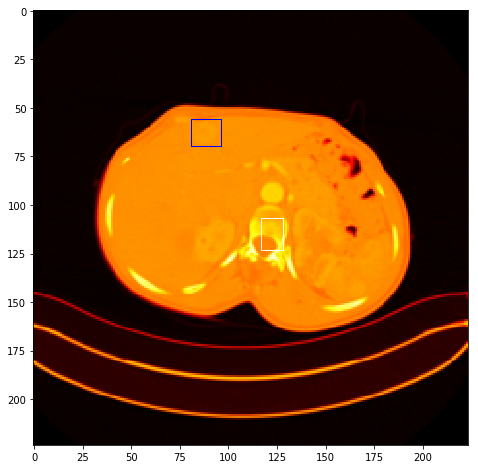

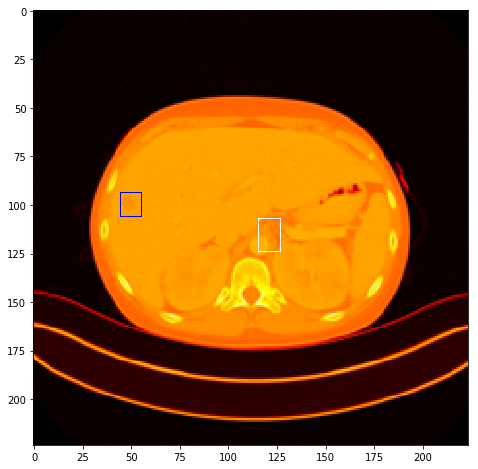

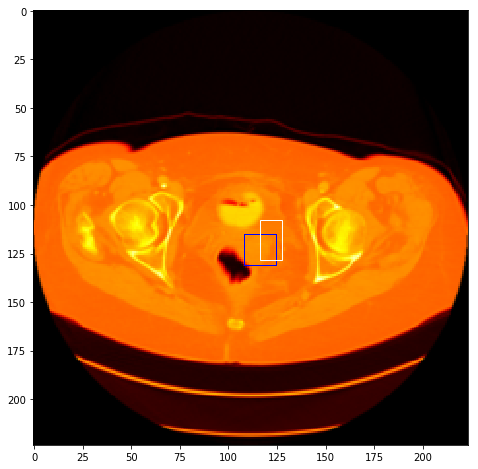

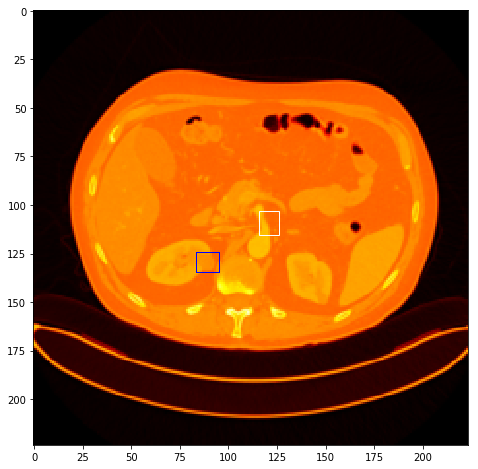

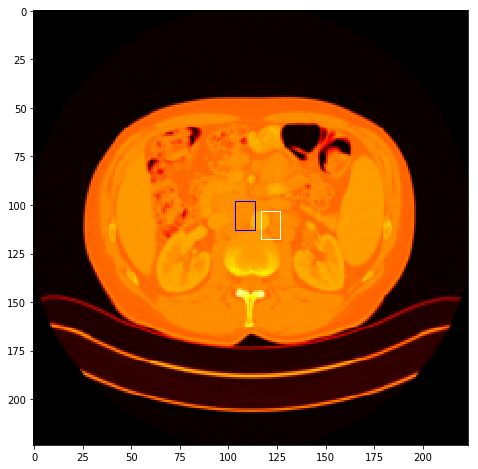

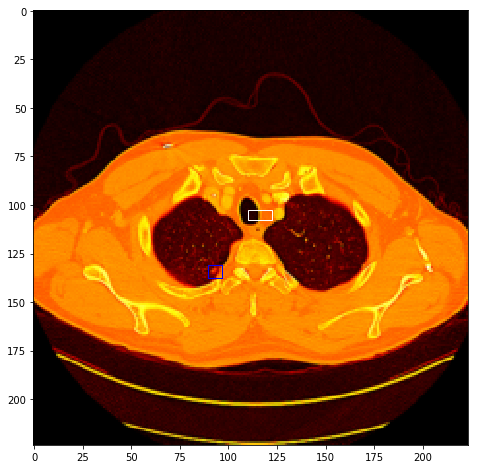

In [17]:
visualize_model(model_ft)

In [ ]:
d[0][0].unsqueeze(0).shape

In [ ]:
model_ft

In [ ]:
def check_output(model, criterion):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels, bb) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            bb = bb.to(device)

            outputs = torch.sigmoid(model(inputs))

            loss = criterion(outputs.view(-1, 1), bb.view(-1, 1))
            print(outputs)
            print(bb)
            print('l', loss)
            print(loss.sum(dim=1))
#             print(loss.item())
            return outputs, bb
            break
    model.train(mode=was_training)

o, bb = check_output(model_ft, nn.PairwiseDistance())

In [ ]:
for inputs, target in dataloaders['train']:
    inputs = inputs.to(device)
    target = target.to(device)
    pred = model_ft(inputs)
    pred = pred.view(inputs.size()[0], 7, 7, 11)
#     conf_bboxes()
#     print(target)
#     print(pred.view(inputs.size()[0], 7, 7, 11))
    break


In [ ]:
model_ft = YOLONet()
pp = 0
for p in model_ft.parameters():
    if p.requires_grad:
        n_n=1
        for s in list(p.size()):
            n_n = n_n*s
        pp += n_n
print(pp)

In [ ]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7*7*11)
model_ft(d[0][0].unsqueeze(0)).view(-1, 7, 7, 11)